# Deep Convolutional GAN
In this notebook, we will build a **generative model** using neural networks. 

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs). In a GAN, we build two different neural networks:

*   **Discriminator**: this is a classification network. We will train the discriminator to take images and classify them as being real (belonging to the training set) or fake (not present in the training set).
*   **Generator**: We will train the generator to take random noise as input and transform it to an image. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

Here, we will implement an all convolutional GAN, inspired by Deep Convolutional GAN (DCGAN) as described in the paper ["Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks"](https://arxiv.org/pdf/1511.06434.pdf) by Radford et. al.
 

In [ ]:
#@title Installations and Mounting
# installations
!pip install livelossplot --quiet

# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
import sys
from pathlib import Path

def check_assignment(assignment_dir, files_list):
  files_in_dir = set(os.listdir(assignment_dir))
  for fname in files_list:
    if fname not in files_in_dir:
      raise FileNotFoundError(f'could not find file: {fname} in assignment_dir')

assignment_dest = "/content/hw4"
assignment_dir = "/content/gdrive/My Drive/DL4CV/hw4"  #@param{type:"string"}
#assignment_files = ['hw1.ipynb', 'model.py', 'test_model.py', 'train.py', 'utils.py']

assignment_files = (Path(assignment_dir) / 'DCGAN').glob('**/*')
assignment_files = [f for f in assignment_files if f.is_file()]

# check Google Drive is mounted
if not os.path.isdir("/content/gdrive"):
  raise FileNotFoundError("Your Google Drive isn't mounted. Please run the above cell.")

# check all files there
#check_assignment(assignment_dir, assignment_files)

# create symbolic link
!rm -f {assignment_dest}
!ln -s "{assignment_dir}" "{assignment_dest}"
print(f'Succesfully mapped (ln -s) "{assignment_dest}" -> "{assignment_dir}"')

# cd to linked dir
root = Path(assignment_dest) / 'DCGAN'
%cd -q {str(root)}
print(f'Succesfully changed directory (cd) to "{str(root)}"')

# create zssr constants
if str(root) not in sys.path:
  sys.path.append(str(root)) 


In [1]:
# import calls
import torch
import matplotlib.pyplot as plt  
#from pathlib import Path

%load_ext autoreload
%autoreload 2

In [2]:
import os

os.getcwd()
os.chdir("/home/labs/antebilab/guyilan/Courses/DL4CV/hw4/DCGAN")

## 1. Data handling
We will work on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). 

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from config import Config

conf = Config()

img_transform = transforms.Compose([
    transforms.Resize(conf.img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=conf.batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_loader = DataLoader(test_dataset, batch_size=conf.batch_size, shuffle=True)

Init config successfully


## 2. Implement a generator and discrominator for DCGAN

Our first step is to build the architecture of the generator and the discriminator of our GAN.


### 2.2 Generator

The generator is designed to map the latent space vector to data-space. This is accomplished through a series of strided [2D transposed convolution layers](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html), following a [2D batch normalization layer](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) to imporve the flow of gradients during training, and a ReLU activation. The output of the generator is passed through a `TanH` function to clip the image to be in the range of [-1,1]. 
The output of the generator has the shape of `[batch_size, 1, 32, 32]`.

The architecture is:
* Input is the latent vector: latent_dim x 1 x 1
* 2D transposed convolution: 256 Filters, kernel_size 4x4, stride 1, padding 0
* Batch Normalization
* ReLU
* 2D transposed convolution: 128 Filters, kernel_size 4x4, stride 2, padding 1
* Batch Normalization
* ReLU
* 2D transposed convolution: 64 Filters, kernel_size 4x4, stride 2, padding 1
* Batch Normalization
* ReLU
* 2D transposed convolution: 1 Filter, kernel_size 4x4, stride 2, padding 1
* `TanH`

Conv layers should not include bias terms.

You should open the `model.py` file and add your solution to the designated areas. You can do so by opening the `model.py` file (by clicking on this link: `/content/hw4/DCGAN/model.py`). Alternatively, you can go the left menu, click on **Files (📁)**, go to the directory `DCGAN` (or `content/hw4/DCGAN`) and double-click on `model.py`.

**Note:** For visulization of transposed convolution, follow this [link](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md).

**Note:** The files in this assignment are auto-imported in this notebook. It means that you can change them, save them (`Ctrl+S`) and this change will immediately take affect in the notebook (when you use these functions again). You can use the dedicated playground cells to debug your code.


In [4]:
# playground for debugging Generator
from model import Generator

In [5]:
!python -m unittest test_model.TestModel.testGeneratorOutput
!python -m unittest test_model.TestModel.testGeneratorParams

Init config successfully
.
----------------------------------------------------------------------
Ran 1 test in 1.920s

OK
Init config successfully
.
----------------------------------------------------------------------
Ran 1 test in 0.281s

OK


### 2.1 Discriminator
The discriminator is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). This is accomplished through a series of strided 2D convolution layers (enable the network to learn its own downsampling mechanisem), batch normalization, and [Leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) activations that promote good gradient flow. The output of the discriminator is passed through a Sigmoid activation function to output the final probability. The output of the discriminator have the shape of `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

The architecture is:
* Input is the real/fake image: 1 x 32 x 32
* 2D convolution: 64 Filters, kernel_size 4x4, stride 2, padding 1
* Leaky ReLU (alpha=0.02)
* 2D convolution: 64*2 Filters, kernel_size 4x4, stride 2, padding 1 
* Batch Normalization
* Leaky ReLU (alpha=0.02)
* 2D convolution: 64*4 Filters, kernel_size 4x4, stride 2, padding 1 
* Batch Normalization
* Leaky ReLU (alpha=0.02)
* 2D convolution: 1 Filter, 4x4, kernel_size 4x4, stride 1, padding 0
* Sigmoid

Conv layers should not include bias terms.

You should open the `model.py` file and add your solution to the designated areas. You can do so by opening the `model.py` file (by clicking on this link: `/content/hw4/DCGAN/model.py`). Alternatively, you can go the left menu, click on **Files (📁)**, go to the directory `DCGAN` (or `content/hw4/DCGAN`) and double-click on `model.py`.

**Note:** The files in this assignment are auto-imported in this notebook. It means that you can change them, save them (`Ctrl+S`) and this change will immediately take affect in the notebook (when you use these functions again). You can use the dedicated playground cells to debug your code.


In [6]:
# playground for debugging Discriminator
from model import Discriminator

In [7]:
!python -m unittest test_model.TestModel.testDiscriminatorOutput
!python -m unittest test_model.TestModel.testDiscriminatorParams

Init config successfully
.
----------------------------------------------------------------------
Ran 1 test in 0.774s

OK
Init config successfully
.
----------------------------------------------------------------------
Ran 1 test in 0.251s

OK


## 3. Implement the adversarial training mechanism

In this section you will implement the DCGAN adversarial training mechanism. We can think of the optimization as a back and forth process of the generator ($G$) trying to fool the discriminator ($D$) and the discriminator trying to correctly classify real vs. fake. 

To optimize, we will use the Binary Cross Entropy loss ([BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss)) and alternate the following updates:
1. Update the **generator** ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the generator $G$, and $D$ is the output of the discriminator.
2. Update the **discriminator** ($D$) to maximize the probability of the discriminator making the correct choice on real and generated data.
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are the real images sampled from the dataset.

Preliminary steps:
1. Construct a batch of real samples from the training set.
2. Construct a batch of fake samples by first sampling latent priors and them passing them through $G$.
3. Generate adversarial ground truths lables.

Update discriminator:
1. Forward the batch of real images through $D$ to get $D(x)$.
2. Calculate the loss ($log(D(x)$), then calculate the gradients in a backward pass.
3. Forward the batch of fake images  through $D$ to get $D(G(z))$. **You sould detach the computation graph of the generator so that gradients are not backpropagated into it**.
4. Calculate the loss ($log(1-D(G(z)))$) and accumulate the gradients with a backward pass.
5. Call a step of $D$’s optimizer with the gradients accumulated from both the all-real and all-fake batches.

Update generator:
1. Classify $G$’s output with $D$ (again).
2. Compute $G$’s loss (which labels should you use as GT?), and accumulate $G$’s gradients in a backward pass.
3. Call a step of $G$’s optimizer to update $G$’s parameters.

You should open the `train.py` file and add your solution to the designated areas. You can do so by opening the `train.py` file (by clicking on this link: `/content/hw4/DCGAN/train.py`). Alternatively, you can go the left menu, click on **Files (📁)**, go to the directory `DCGAN` (or `content/hw4/DCGAN`) and double-click on `train.py`.

**Note:** The files in this assignment are auto-imported in this notebook. It means that you can change them, save them (`Ctrl+S`) and this change will immediately take affect in the notebook (when you use these functions again). You can use the dedicated playground cells to debug your code.


In [8]:
# playground for debugging the training
from train import train_epoch

## 4. Train

In this part you will need to use GPU. To get a GPU in Google Colab, please go to the top menu and to: **Runtime ➔ Change runtime type**. Then, select **GPU** as **Hardware accelerator**. Since your GPU time in Google colab is limited, please change your runtime type to GPU only when you finished debugging your model.

Once finished, please run the cells below to train your model.

You are expected to train for 5 epochs and qualitatively see an improvement in the results.

**Note:** You are encouraged to try and run the training for a longer number of epochs **after submitting the assignment**. 

**Note:** Your GPU time in Google Colab is limited, please change your runtime type to 'None' after completing the training and generate sections.


Train Epoch: 001 / 010


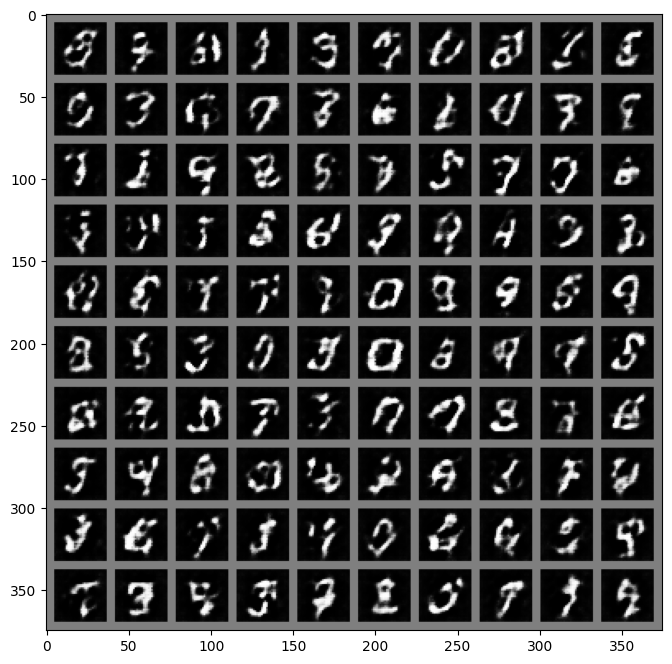

Train Epoch: 002 / 010


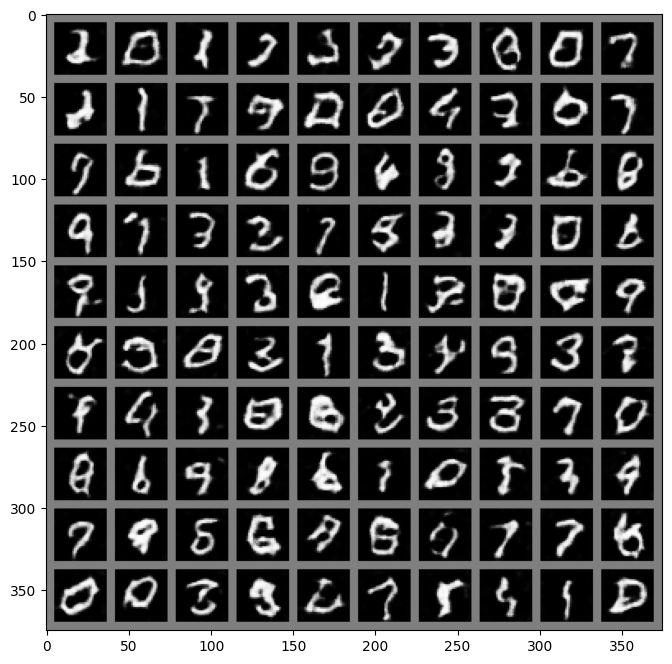

Train Epoch: 003 / 010


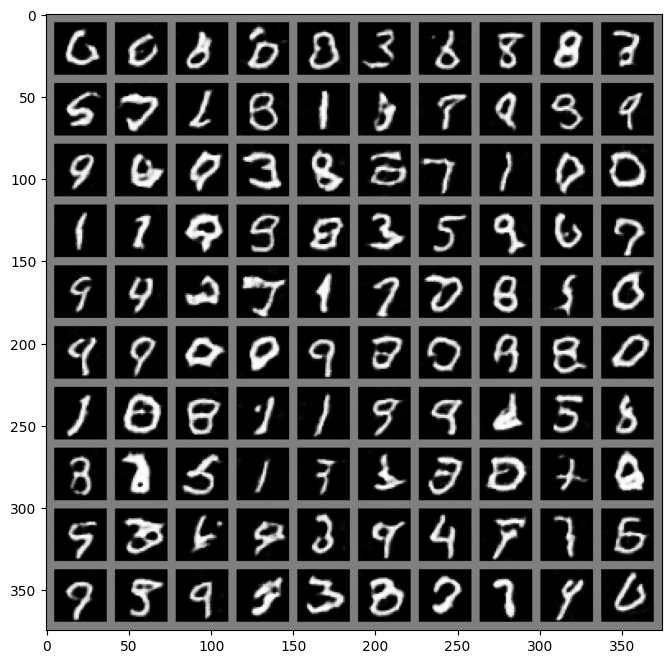

Train Epoch: 004 / 010


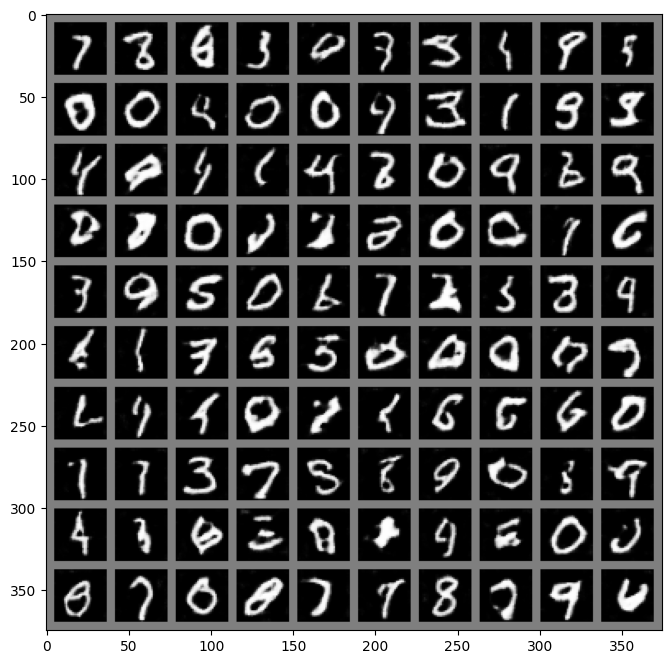

Train Epoch: 005 / 010


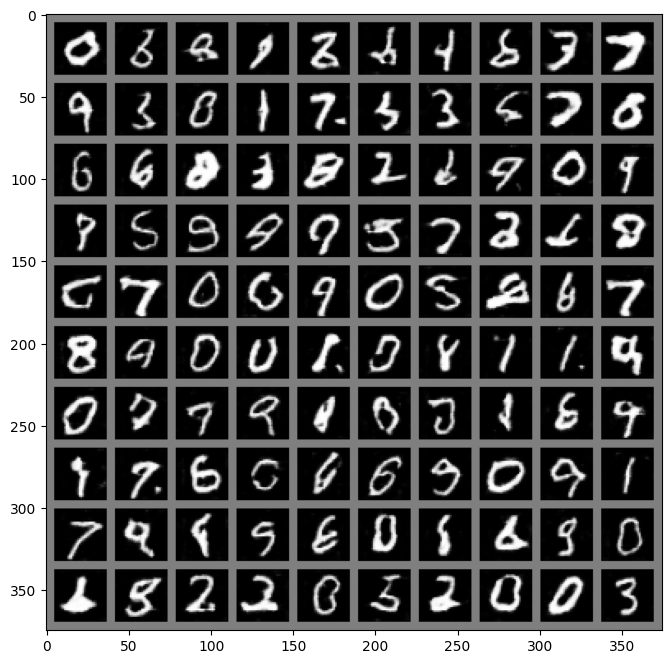

Train Epoch: 006 / 010


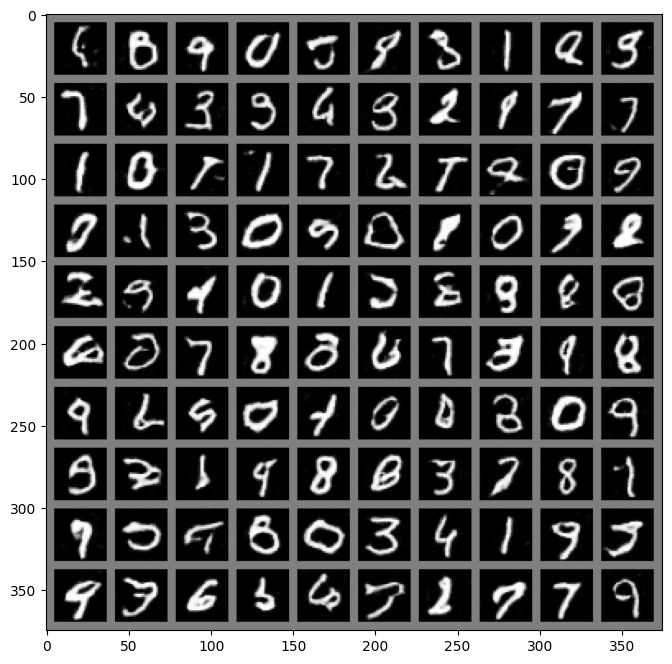

Train Epoch: 007 / 010


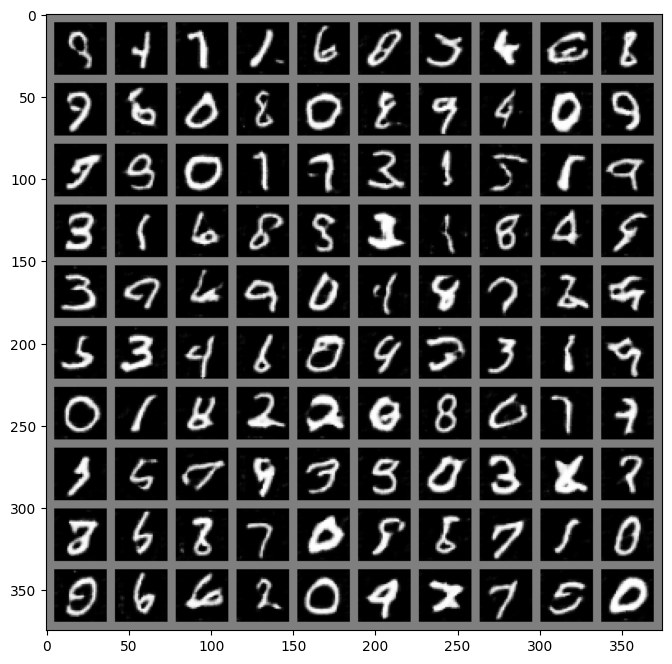

Train Epoch: 008 / 010


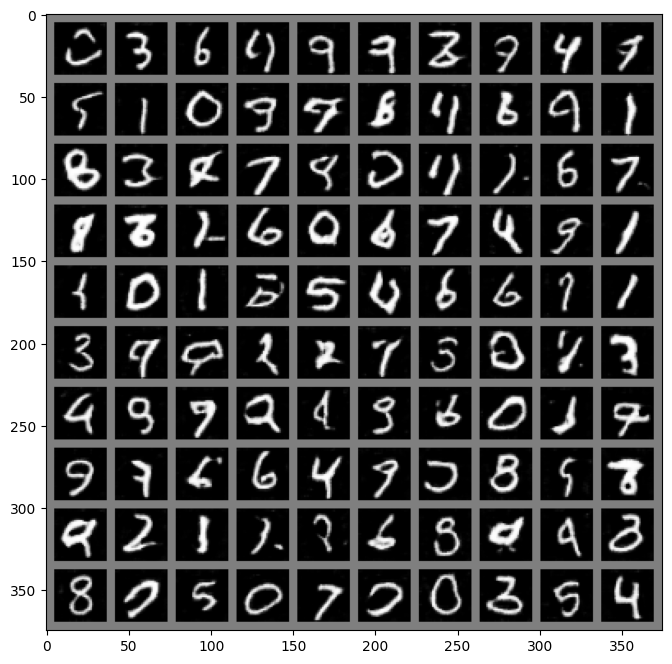

Train Epoch: 009 / 010


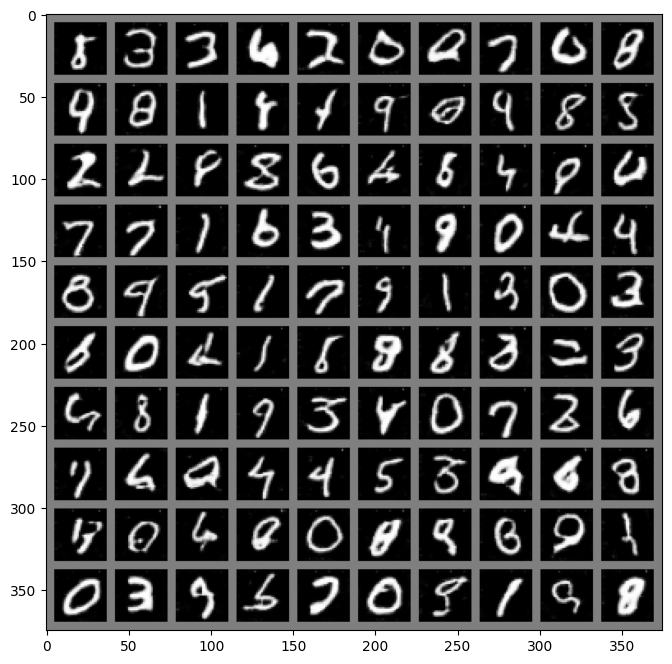

Train Epoch: 010 / 010


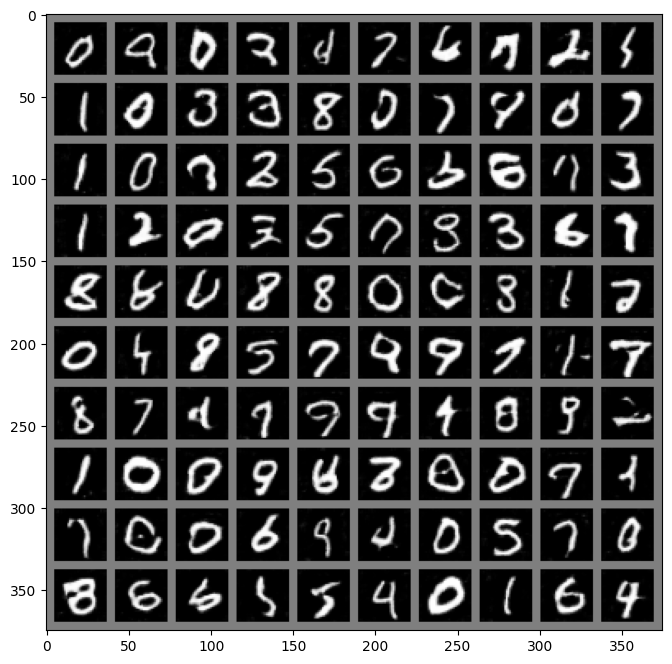

In [12]:
from model import *
from train import train_loop

# Define your generator and transfer it to device
generator = Generator(conf)
generator = generator.to(conf.device)

# Define your discriminator and transfer it to device
discriminator = Discriminator(conf)
discriminator = discriminator.to(conf.device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Set an optimizer for the generator:
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=conf.lr, betas=(conf.b1, conf.b2))

# Set an optimizer for the discriminator:
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=conf.lr, betas=(conf.b1, conf.b2))

# Set critertion
criterion = torch.nn.BCELoss()

# Train your model
g_l, d_l = train_loop(generator=generator,
          discriminator=discriminator, 
          criterion=criterion,
          gen_optimizer=gen_optimizer,
          disc_optimizer = disc_optimizer, 
          dataloader=train_loader,
          conf=conf)

In [ ]:
#@title # Create and Download Your Solution
import os
import re
import zipfile
from google.colab import files

os.chdir('..')

def create_zip(files, hw, name):
  zip_path = f'{hw}-{name}.zip'
  with zipfile.ZipFile(zip_path, 'w') as f:
    for fname in files:
      if not os.path.isfile(fname):
        os.chdir('./DCGAN')
        raise FileNotFoundError(f"Couldn't find file: '{fname}' in the homework directory")
      f.write(fname, fname)
  return zip_path
# export notebook as html
!jupyter nbconvert --to html DCGAN/main.ipynb
##@markdown Please upload your typed solution (`.pdf` file) to the homework directory, and use the name `hw2-sol.pdf`.
#@markdown **Important:** your notebook should run from top to bottom.
#@markdown You can check it by going to the top menu and to: **Runtime ➔ Restart and run all**. 
#@markdown Make sure to have all the cell's output printed (including the training output!) before downloading.
student_name = "Jane Doe"  #@param{type:"string"}
assignment_name = 'hw4' 
assignment_sol_files = ['ViT.ipynb', 'ViT.html', 'functional.py', 'nn.py', 'models.py',
                        'DCGAN/main.ipynb', 'DCGAN/main.html', 'DCGAN/train.py', 'DCGAN/model.py']
zip_name = re.sub('[_ ]+', '_', re.sub(r'[^a-zA-Z_ ]+', '', student_name.lower()))
# create zip with your solution
zip_path = create_zip(assignment_sol_files, assignment_name, zip_name)

os.chdir('./DCGAN')

# download the zip
files.download("../" + zip_path)

#@markdown Enter your name in `student_name` and run this cell to create and download a `.zip` file with your solution.
#@markdown You should submit your solution via Moodle.

#@markdown **Note:** If you run this cell multiple times, you may be prompted by the browser to allow this page to download multiple files.